In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt
!pip install timm
from timm.models.layers import DropPath
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy

!pip install git+https://github.com/facebookresearch/pycls.git

import numpy as np
from torch.utils.data import Subset

from torchvision import transforms
from torchvision.transforms import InterpolationMode
from timm.data import create_loader
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data.random_erasing import RandomErasing
from torchvision.datasets import CIFAR10
import torch
from torch.optim.lr_scheduler import LambdaLR

import math

from timm.loss import LabelSmoothingCrossEntropy


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


  Cloning https://github.com/facebookresearch/pycls.git to /tmp/pip-req-build-cb_het_h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pycls.git /tmp/pip-req-build-cb_het_h
  Resolved https://github.com/facebookresearch/pycls.git to commit 5719de641657c251f807c20a1fcf8ef6f4b60144
  Preparing metadata (setup.py) ... done


In [ ]:
from re import X
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.msa = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
        )

    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        x, _ = self.msa(x, x, x)
        x = x + x_res

        x_res = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = x + x_res

        return x


class ViT(nn.Module):
    # NOTE: we took the following dimensions from the paper: d_model = 192, patch_size = 16, img_size = 224, dropout = 0.1
    def __init__(self, d_model=192, num_layers=12, num_classes=10, patch_size=16, img_size=224, dropout=0.1, mode = 'both'):
        super().__init__()
        self.mode = mode
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * 3

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.LayerNorm(self.patch_dim),
            nn.Linear(self.patch_dim, d_model),
            nn.LayerNorm(d_model),
        )
        if mode in ['class', 'both']:
            self.class_token = nn.Parameter(torch.randn(1, 1, d_model))
        if mode in ['distill', 'both']:
            self.distill_token = nn.Parameter(torch.randn(1, 1, d_model))
        token_count = {
            'none': 0,
            'soft': 0,
            'hard': 0,
            'class': 1,
            'distill': 1,
            'both': 2,
        }[mode]
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + token_count, d_model))
        self.dropout = nn.Dropout(dropout)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads=d_model // 64, dropout=dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if self.mode == 'class':
            class_tok = self.class_token.expand(x.shape[0], -1, -1)
            x = self.to_patch_embedding(x)
            x = torch.cat([class_tok, x], dim=1)
        elif self.mode == 'distill':
            dist_tok = self.distill_token.expand(x.shape[0], -1, -1)
            x = self.to_patch_embedding(x)
            x = torch.cat([dist_tok, x], dim=1)
        elif self.mode == 'both':
            class_tok = self.class_token.expand(x.shape[0], -1, -1)
            dist_tok = self.distill_token.expand(x.shape[0], -1, -1)
            x = self.to_patch_embedding(x)
            x = torch.cat([class_tok, dist_tok, x], dim=1)

        x = x + self.pos_embedding[:, :x.size(1)]
        x = self.dropout(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.norm(x)
        if self.mode in ['none', 'soft', 'hard']:
            pooled = x.mean(dim=1)
            return self.head(pooled), None
        elif self.mode == 'class':
            return self.head(x[:, 0]), None
        elif self.mode == 'distill':
            return None, self.head(x[:, 0])
        elif self.mode == 'both':
            return self.head(x[:, 0]), self.head(x[:, 1])
        else:
            print("NONEXISTENT MODE")





In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, mixup_fn):
    model.train()
    total_loss = 0
    correct = 0
    num_samples = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        if mixup_fn is not None:
            images, labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        out_class, out_dist = model(images)
        loss = criterion((out_class, out_dist), labels, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        num_samples += images.size(0)

        if labels.ndim == 2:
            labels_hard = labels.argmax(dim=1)
        else:
            labels_hard = labels

        if out_class is not None and out_dist is not None:
            preds = ((out_class + out_dist) / 2).argmax(dim=1)
        elif out_class is not None:
            preds = out_class.argmax(dim=1)
        elif out_dist is not None:
            preds = out_dist.argmax(dim=1)

        correct += preds.eq(labels_hard).sum().item()
        num_samples += images.size(0)
    return total_loss / num_samples, (correct / num_samples) * 100

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    num_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            out_class, out_dist = model(images)
            loss = criterion((out_class, out_dist), labels, images)
            total_loss += loss.item() * images.size(0)
            if out_class is not None and out_dist is not None:
                preds = ((out_class + out_dist) / 2).argmax(dim=1)
            elif out_class is not None:
                preds = out_class.argmax(dim=1)
            elif out_dist is not None:
                preds = out_dist.argmax(dim=1)
            else:
                print("something wrong with preds eval")
            correct += preds.eq(labels).sum().item()
            num_samples += labels.size(0)

    return total_loss / num_samples, (correct / num_samples) * 100


In [ ]:
from torchvision.transforms import RandAugment
mixup_fn = Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    prob=1.0,
    switch_prob=0.5,
    mode='batch',
    label_smoothing=0.1,
    num_classes=10
)
IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    RandomErasing(probability=0.25, mode='const')
])

transform_test = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True) #if throwing fork error, just change num_workers to 0
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# CNN (teacher model)

In [ ]:
import torchvision.models as models
regnet = models.regnet_x_400mf(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, base_criterion=None, teacher_model=None, mode='both', lambda_=0.5, temperature=2.0):
        super().__init__()
        self.base_criterion = base_criterion or nn.CrossEntropyLoss()
        self.soft_cross= SoftTargetCrossEntropy()
        self.teacher_model = teacher_model
        self.lambda_ = lambda_
        self.temperature = temperature
        self.mode = mode
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, outputs, labels, inputs):
        out_class, out_dist = outputs
        def ce(pred, target):
            if target.ndim == 2:
                return self.soft_cross(pred, target)
            return self.base_criterion(pred, target)

        if self.mode == 'none':
            return ce(out_class, labels)

        if self.teacher_model is not None:
            with torch.no_grad():
                teacher_logits = self.teacher_model(inputs)

        if self.mode == 'soft':
            teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)
            student_log_probs = F.log_softmax(out_dist / self.temperature, dim=1)
            distill_loss = self.kl_div(student_log_probs, teacher_probs) * (self.temperature ** 2)
            ce_loss = ce(out_class, labels)
            return (1. - self.lambda_) * ce_loss + self.lambda_ * distill_loss

        elif self.mode == 'hard':
            teacher_labels = teacher_logits.argmax(dim=1)
            ce_gt = ce(out_class, labels)
            ce_teacher = ce(out_dist, teacher_labels)
            return 0.5 * ce_gt + 0.5 * ce_teacher

        elif self.mode == 'class':
            return ce(out_class, labels)

        elif self.mode == 'distill':
            teacher_labels = teacher_logits.argmax(dim=1)
            return ce(out_dist, teacher_labels)

        elif self.mode == 'both':
            teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)
            student_log_probs = F.log_softmax(out_dist / self.temperature, dim=1)
            distill_loss = self.kl_div(student_log_probs, teacher_probs) * (self.temperature ** 2)
            ce_loss = ce(out_class, labels)
            return (1. - self.lambda_) * ce_loss + self.lambda_ * distill_loss

        else:
            print("NON EXISTENT MODE")


In [ ]:
model = ViT().to(device)
# CHANGE THIS LINE TO none | soft | hard | class | distill | both TO RUN MODELS
distill_mode = 'none'
if distill_mode != 'none':
    teacher = regnet
    teacher.fc = nn.Linear(400, 10)
    teacher = teacher.to(device)
    teacher.eval()
else:
    teacher = None

label_smoothing = LabelSmoothingCrossEntropy()
criterion = DistillationLoss(base_criterion=LabelSmoothingCrossEntropy(smoothing=0.1), teacher_model=teacher, mode=distill_mode)

batch_size = 64
base_lr = 0.0005
scaled_lr = base_lr * batch_size / 512
optimizer = optim.AdamW(model.parameters(), lr=scaled_lr, weight_decay=0.05)

def warmup_cosine_lr_schedule(epoch, warmup_epochs=5, total_epochs=50):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_cosine_lr_schedule(epoch, warmup_epochs=5, total_epochs=50))

train_accs = []
val_accs = []
val_losses = []

for epoch in range(1, 21):
    train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device, mixup_fn=None)
    train_accs.append(train_acc)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    scheduler.step()
    print("Epoch " + str(epoch) + ": train acc=" + str(round(train_acc, 2)) + "%, val acc=" + str(round(val_acc, 2)) + "%")

100%|██████████| 782/782 [06:24<00:00,  2.03it/s]


Epoch 1: train acc=5.27%, val acc=10.57%


100%|██████████| 782/782 [06:21<00:00,  2.05it/s]


Epoch 2: train acc=8.86%, val acc=24.82%


100%|██████████| 782/782 [06:20<00:00,  2.05it/s]


Epoch 3: train acc=10.54%, val acc=27.99%


100%|██████████| 782/782 [06:22<00:00,  2.04it/s]


Epoch 4: train acc=12.0%, val acc=33.86%


100%|██████████| 782/782 [06:22<00:00,  2.05it/s]


Epoch 5: train acc=14.04%, val acc=42.56%


100%|██████████| 782/782 [06:15<00:00,  2.08it/s]


Epoch 6: train acc=15.0%, val acc=44.44%


100%|██████████| 782/782 [06:14<00:00,  2.09it/s]


Epoch 7: train acc=16.32%, val acc=48.74%


100%|██████████| 782/782 [06:14<00:00,  2.09it/s]


Epoch 8: train acc=17.04%, val acc=49.9%


100%|██████████| 782/782 [06:13<00:00,  2.09it/s]


Epoch 9: train acc=17.81%, val acc=51.54%


100%|██████████| 782/782 [06:17<00:00,  2.07it/s]


Epoch 10: train acc=18.07%, val acc=54.8%


100%|██████████| 782/782 [06:20<00:00,  2.05it/s]


Epoch 11: train acc=19.19%, val acc=53.65%


100%|██████████| 782/782 [06:19<00:00,  2.06it/s]


Epoch 12: train acc=19.42%, val acc=56.29%


100%|██████████| 782/782 [06:19<00:00,  2.06it/s]


Epoch 13: train acc=20.22%, val acc=56.57%


100%|██████████| 782/782 [06:19<00:00,  2.06it/s]


Epoch 14: train acc=20.73%, val acc=57.53%


100%|██████████| 782/782 [06:20<00:00,  2.05it/s]


Epoch 15: train acc=20.58%, val acc=59.75%


100%|██████████| 782/782 [06:20<00:00,  2.05it/s]


Epoch 16: train acc=21.5%, val acc=60.11%


100%|██████████| 782/782 [06:19<00:00,  2.06it/s]


Epoch 17: train acc=21.83%, val acc=61.98%


100%|██████████| 782/782 [06:20<00:00,  2.06it/s]


Epoch 18: train acc=22.12%, val acc=62.4%


100%|██████████| 782/782 [06:20<00:00,  2.06it/s]


Epoch 19: train acc=22.27%, val acc=59.5%


100%|██████████| 782/782 [06:21<00:00,  2.05it/s]


Epoch 20: train acc=22.57%, val acc=61.69%


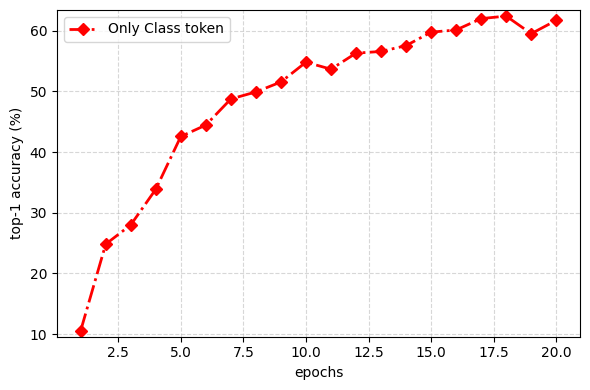

In [ ]:
epochs_range = range(1, len(val_accs) + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, val_accs, color='red', marker='D', linestyle='-.', linewidth=2, label='Only Class token')
plt.xlabel('epochs')
plt.ylabel('top-1 accuracy (%)')
plt.ylim(min(val_accs) - 1, max(val_accs) + 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("graph.png", dpi=300)

<Figure size 640x480 with 0 Axes>